## Replication and Extension of Paper:

Dobs, Katharina & Yuan, Joanne & Martinez, Julio & Kanwisher, Nancy. (2022). Using deep convolutional neural networks to test why human face recognition works the way it does. 10.1101/2022.11.23.517478. 


In [1]:
import os
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import correlation
import torch
from torchvision import transforms
from PIL import Image
from scipy.stats import spearmanr
import numpy as np
from facenet_pytorch import InceptionResnetV1, MTCNN
from scipy.stats import pearsonr
import torchvision.models as models
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import vgg16
from tqdm.notebook import tqdm

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Defining functions for preprocessing images

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

preprocess = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [3]:
def load_model(name,num_classes):
    
    model = models.vgg16()
    
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the classifier layer to match the number of classes in your problem
    
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, num_classes) # HAALP
    
    # model.load_state_dict(torch.load('../models/'+name+'.pth')) #if you wish to load model from GPU
    model.load_state_dict(torch.load('../models/'+name+'.pth', map_location=torch.device('cpu'))) #if you wish to load model from CPU
    
    model.eval()
    
    return model

In [4]:
#Declaring the pretrained models used:

FACE_ID_CNN = InceptionResnetV1(pretrained='vggface2').eval()
UNTRAINED = models.vgg16(pretrained=False)
OBJ_CLASSIFICATION = models.vgg16(pretrained=True)
FACE_FEATURE_EXTRACTION = MTCNN(image_size=160, margin=0, min_face_size=20, thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True)


/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
FACE_ID_INVERTED_CNN = load_model('Face_ID_Inverted_CNN', 101)
# FACE_ID_ASIAN_CNN = load_model('Asian_Face_ID_CNN',107)
# FACE_ID_WHITE_CNN = load_model('White_Face_ID_CNN', 115)
# CARS_CNN = load_model('Cars_CNN',43 )
# OBJ_FACE_CLASSIFICATION = load_model_name('Obj_Face_Classification')
# FACE_ID_CNN_2 = load_model_name('Face_ID_CNN_2')
# FACE_ID_CNN_2 = load_model('Face_ID_CNN_2', 101)




In [6]:
print(FACE_ID_CNN)

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [7]:
from torch.autograd import Variable
def target_matching_vgg16(model, stimuli_path, start_num,end_num):
    image_folder = stimuli_path
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')]
    images = []
    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    model.classifier[4].register_forward_hook(get_activation('classifier'))
    for image_path in image_paths:
        img = Image.open(image_path)
        # Preprocess images
        image = preprocess(img)
        # Add batch dimension
        img_tensor = image.unsqueeze(0)
        # Get penultimate layer activations
        
        #CHANGE CODE HERE*****
        
        output = model(img_tensor)
        # print(output)
        # images.append(output)

        penultimate_layer_activation = activations['classifier'][0].numpy()
        # print(penultimate_layer_activation)
        images.append(penultimate_layer_activation)
    
    #Getting Accuracy Scores by comparing two images to a target image

    total = 0
    correct= 0

    for i in range (start_num,int(end_num),5):
        r1 = np.random.randint(0,5)
        r2 = np.random.randint(0,5)
        while r2==r1:
            r2 = np.random.randint(0,5)
        for j in range (start_num,int(end_num),5):
            if(i!=j):
                dist = 1 - pearsonr(images[i+r1],images[i+r2]).statistic
                dist2 = 1 - pearsonr(images[i+r1],images[j+r2]).statistic
                total+=1
                if(dist<dist2):
                    correct+=1
            
    accuracy = correct/total
    
    return accuracy
    

In [12]:
def target_matching_resnet(model, stimuli_path, start_num,end_num):
    image_folder = stimuli_path
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')]
    images = []
    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    model.last_linear.register_forward_hook(get_activation('classifier'))
    for image_path in image_paths:
        img = Image.open(image_path)
        # Preprocess images
        image = preprocess(img)
        # Add batch dimension
        img_tensor = image.unsqueeze(0)
        # Get penultimate layer activations
        
        #CHANGE CODE HERE*****
        
        output = model(img_tensor)
        # print(output)
        # images.append(output)

        penultimate_layer_activation = activations['classifier'][0].numpy()
        # print(penultimate_layer_activation)
        images.append(penultimate_layer_activation)
    
    #Getting Accuracy Scores by comparing two images to a target image

    total = 0
    correct= 0

    for i in range (start_num,int(end_num),5):
        r1 = np.random.randint(0,5)
        r2 = np.random.randint(0,5)
        while r2==r1:
            r2 = np.random.randint(0,5)
        for j in range (start_num,int(end_num),5):
            if(i!=j):
                dist = 1 - pearsonr(images[i+r1],images[i+r2]).statistic
                dist2 = 1 - pearsonr(images[i+r1],images[j+r2]).statistic
                total+=1
                if(dist<dist2):
                    correct+=1
            
    accuracy = correct/total
    
    return accuracy

In [13]:
# TASK 1, Identity Matching (Checking the perforances of various CNNs trained for different specialisations on the task of identity matching)
# Selecting the face identical to target face out of the two given face images. 
# Human Accuracy ~ 90% (Exact replication not possible as the sets of three stimuli used were not provided to us by the authors)

t1_start=0
t1_end=400
t1_path = './Task_1/'

FACE_ID_CNN_Accuracy1 = target_matching_resnet(FACE_ID_CNN,t1_path,t1_start,t1_end)
# # untrained_Accuracy1 = target_matching(UNTRAINED,t1_path,t1_start,t1_end)
# obj_classification_Accuracy1 = target_matching(OBJ_CLASSIFICATION,t1_path,t1_start,t1_end)
FACE_ID_INVERTED_CNN_Accuracy1 = target_matching_vgg16(FACE_ID_INVERTED_CNN,t1_path,t1_start,t1_end)


ValueError: x and y must have length at least 2.

In [10]:
print(FACE_ID_CNN_Accuracy1, FACE_ID_INVERTED_CNN_Accuracy1)

0.4288461538461538 0.49935897435897436


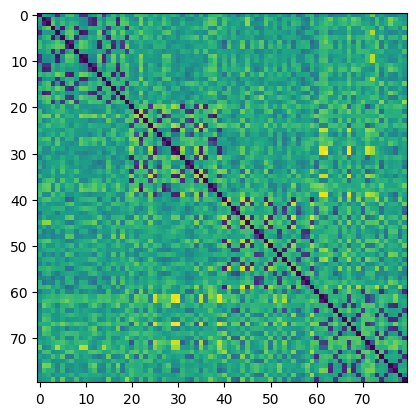

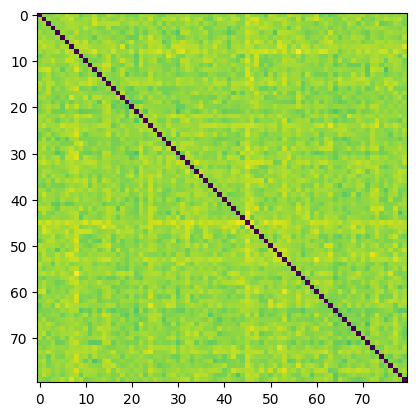

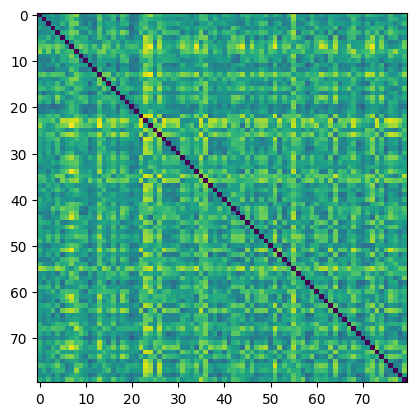

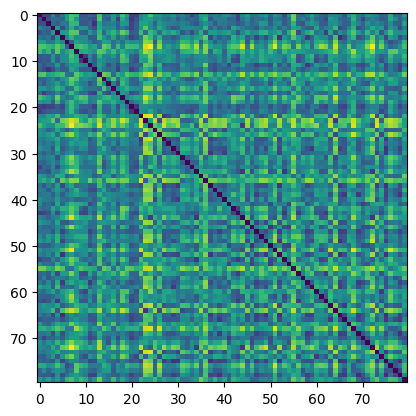

In [14]:
#TASK 2, Alignment Task (Measuring Representational Similarity using RSA)
#The RDMs generated for the pairwise distances between penultimate layer activations of all stimuli are to be compared to that of Human Beings.
#Can't be compared as the Human RDMs were not provided to us by the authors.

def task2(model):
    image_folder = './Task_2/'
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')]
    images = []
    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    if model == FACE_ID_CNN:
        model.last_linear.register_forward_hook(get_activation('classifier'))
    else:
        model.classifier[4].register_forward_hook(get_activation('classifier'))
    for image_path in image_paths:
        img = Image.open(image_path)
        # Preprocess images
        img = img.convert('RGB')
        image = preprocess(img)
        # Add batch dimension
        img_tensor = image.unsqueeze(0)
        # Get penultimate layer activations
        output = model(img_tensor)
        #CHANGE CODE HERE
        penultimate_layer_activation = activations['classifier'][0].numpy()



        images.append(penultimate_layer_activation)


        

    #Generating RDMs for the model
    RDM = pairwise_distances(images, metric='correlation')
    plt.imshow(RDM)
    plt.show()
    # Calculate Spearman rank correlation between network RDM and human behavioral RDM
    # spearman_corr, _ = spearmanr(rdm, human_rdm) ##not availiable-> human_rdm
    # return spearman_corr


task2(FACE_ID_CNN)
task2(UNTRAINED)
task2(OBJ_CLASSIFICATION)
task2(FACE_ID_INVERTED_CNN)

#These RDMS are to be compared to the Human RDMs, and Spearman Rank correlation is to be used to compare each of the 
#RDMs generated by the models to the Human RDMs.

In [ ]:
# Task 3, Similarity Matching
# Human beings were tasked to select the face identical to target face out of the two given face images.
# The performance of the CNNs was then compared with that of these CNNs. Since the dataset used for this task has not been provided, 
# this task cannot be replicated for the time being.

In [ ]:
# Task 4, Verifying Other Race Effect and Face Inversion Effect

# Human beings performed worse when they were asked to identify the target image, given two images if the faces were inverted, or 
# belonged to different ethinicities the participants were not familiar with.

# Testing Face Inversion Effect:



# FACE_ID_CNN_Accuracy4_inversion = task4_inversion(FACE_ID_CNN)
untrained_Accuracy4_inversion = (UNTRAINED)
obj_classification_Accuracy4_inversion = task4_inversion(OBJ_CLASSIFICATION)
# obj_face_classification_Accuracy4_inversion = task4_inversion(OBJ_FACE_CLASSIFICATION)
FACE_ID_INVERTED_CNN_Accuracy4_inversion = task4_inversion(FACE_ID_INVERTED_CNN)

#plot bargraph of each accuracy, with FACE_ID_CNN_Accuracy1 and FACE_ID_CNN_Accuracy4_inversion close togeather, and untrained_Accuracy1 and untrained_Accuracy4_inversion close togeather,
#and obj_classification_Accuracy1 and obj_classification_Accuracy4_inversion close togeather, and obj_face_classification_Accuracy1 and obj_face_classification_Accuracy4_inversion close togeather

# plt.bar([1,2,3,4],[faceID_CNN_Accuracy1,untrained_Accuracy1,obj_classification_Accuracy1,obj_face_classification_Accuracy1])
# plt.bar([1.5,2.5,3.5,4.5],[faceID_CNN_Accuracy4_inversion,untrained_Accuracy4_inversion,obj_classification_Accuracy4_inversion,obj_face_classification_Accuracy4_inversion])
# plt.plot([0,5],[0.9,0.9])
# plt.show()



# Testing Other Race Effect:
# We take CNNs trained only on white faces, and compare this with the performance on target matching as Task 1 with Asian Faces and White faces.
# We then take a CNN based on the same architecture, but trained on Asian faces, and compare this with the performance on target matching as Task 1 with Asian Faces and White faces.
# The performance drops can be compared with that observed in white and asian participants who underwent this task. 

def task4_Asian(model):
    image_folder = './Task_4_other_race/Asian/'
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')]
    images = []
    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    model.classifier[4].register_forward_hook(get_activation('classifier'))

    for image_path in image_paths:
        img = Image.open(image_path)
        # Preprocess images
        image = preprocess(img)
        # Add batch dimension
        img_tensor = image.unsqueeze(0)
        # Get penultimate layer activations
        output = model(img_tensor)
        penultimate_layer_activation = activations['classifier'][0].numpy()
        images.append(penultimate_layer_activation)
    
    #Getting Accuracy Scores by comparing two images to a target image

    total = 0
    correct= 0

    for i in range (0,200,5): #needs to be changed. 
        r1 = np.random.randint(0,5)
        r2 = np.random.randint(0,5)
        while r2==r1:
            r2 = np.random.randint(0,5)
        for j in range (0,200,5): #needs to be changed. 
            if(i!=j):
                dist = 1 - pearsonr(images[i+r1],images[i+r2]).statistic
                dist2 = 1 - pearsonr(images[i+r1],images[j+r2]).statistic
                total+=1
                if(dist<dist2):
                    correct+=1
            
    accuracy = correct/total
    
    return accuracy

def task4_White(model):
    image_folder = './Task_4_other_race/White/'
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')]
    images = []
    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    model.classifier[4].register_forward_hook(get_activation('classifier'))


    for image_path in image_paths:
        img = Image.open(image_path)
        # Preprocess images
        image = preprocess(img)
        # Add batch dimension
        img_tensor = image.unsqueeze(0)
        # Get penultimate layer activations
        output = model(img_tensor)
        penultimate_layer_activation = activations['classifier'][0].numpy()
        images.append(penultimate_layer_activation)
    
    #Getting Accuracy Scores by comparing two images to a target image

    total = 0
    correct= 0

    for i in range (0,200,5): #needs to be changed. 
        r1 = np.random.randint(0,5)
        r2 = np.random.randint(0,5)
        while r2==r1:
            r2 = np.random.randint(0,5)
        for j in range (0,200,5): #needs to be changed. 
            if(i!=j):
                dist = 1 - pearsonr(images[i+r1],images[i+r2]).statistic
                dist2 = 1 - pearsonr(images[i+r1],images[j+r2]).statistic
                total+=1
                if(dist<dist2):
                    correct+=1
            
    accuracy = correct/total
    
    return accuracy

# FACE_ID_WHITE_CNN_Accuracy4_Asian = task4_Asian(FACE_ID_WHITE_CNN)
# FACE_ID_WHITE_CNN_Accuracy4_White = task4_White(FACE_ID_WHITE_CNN)
# FACE_ID_ASIAN_CNN_Accuracy4_Asian = task4_Asian(FACE_ID_ASIAN_CNN)
# FACE_ID_ASIAN_CNN_Accuracy4_White = task4_White(FACE_ID_ASIAN_CNN)
#untrained_Accuracy4_Asian = task4_Asian(UNTRAINED)
#untrained_Accuracy4_White = task4_White(UNTRAINED)
#obj_classification_Accuracy4_Asian = task4_Asian(OBJ_CLASSIFICATION)
#obj_classification_Accuracy4_White = task4_White(OBJ_CLASSIFICATION)
#obj_face_classification_Accuracy4_Asian = task4_Asian(OBJ_FACE_CLASSIFICATION)
#obj_face_classification_Accuracy4_White = task4_White(OBJ_FACE_CLASSIFICATION)

#Plotting the results


# plt.bar([1,2,3,4],[FACE_ID_WHITE_CNN_Accuracy4_Asian,untrained_Accuracy4_Asian,obj_classification_Accuracy4_Asian,obj_face_classification_Accuracy4_Asian])
# plt.bar([1.5,2.5,3.5,4.5],[FACE_ID_WHITE_CNN_Accuracy4_White,untrained_Accuracy4_White,obj_classification_Accuracy4_White,obj_face_classification_Accuracy4_White])
# plt.plot([0,5],[0.9,0.9])
# plt.show()


In [ ]:
# Task 5, Inverted Inversion Effect
# We wish to find out if the drop in performance in inverted faces is 'special' in any sort of way, or is ir just a result of optimisation of 
# our perceptual system. 
# We check the perforance of the Face ID CNN on upright and inverted images and compare how it fares when a CNN trained on inverted faces is
# tested on upright faces as well as inverted faces.

# We also check if such a drop in performance occurs in a CNN specialised in recognising a particular object (We take the example of cars in this case)
# we see if the performance drop occurs when inverted images of cars are presented to these CNNs.

#Inverted Face Inversion Effect

# FACE_ID_INVERTED_CNN_Accuracy5_inverted = task4_inversion(FACE_ID_INVERTED_CNN)
# FACE_ID_INVERTED_CNN_Accuracy5 = task1(FACE_ID_INVERTED_CNN)

#Plot a bar graph with FACE_ID_CNN_Accuracy1, FACE_ID_CNN_Accuracy4_Inverted, FACE_ID_INVERTED_CNN_Accuracy5_inverted and FACE_ID_INVERTED_CNN_Accuracy5 on the x axis and y axis as the accuracy scores.